In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import sobel
from skimage.filters import scharr
import zipfile
import os

In [ ]:
# Path to your .zip file
zip_file = 'Dataset.zip'
# Extract the contents of the zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('main_dataset')  # Extract to a specific directory

In [ ]:
# Directory containing your dataset after extraction
data_dir = 'main_dataset/Dataset - II/Augmented images/Augmented images'

In [ ]:
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
train_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation')

Found 2287 images belonging to 7 classes.
Found 569 images belonging to 7 classes.


In [ ]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
class_weights

{0: 0.868920972644377,
 1: 1.1668367346938775,
 2: 0.6778304682868999,
 3: 0.6778304682868999,
 4: 1.060760667903525,
 5: 1.4204968944099379,
 6: 2.532668881506091}

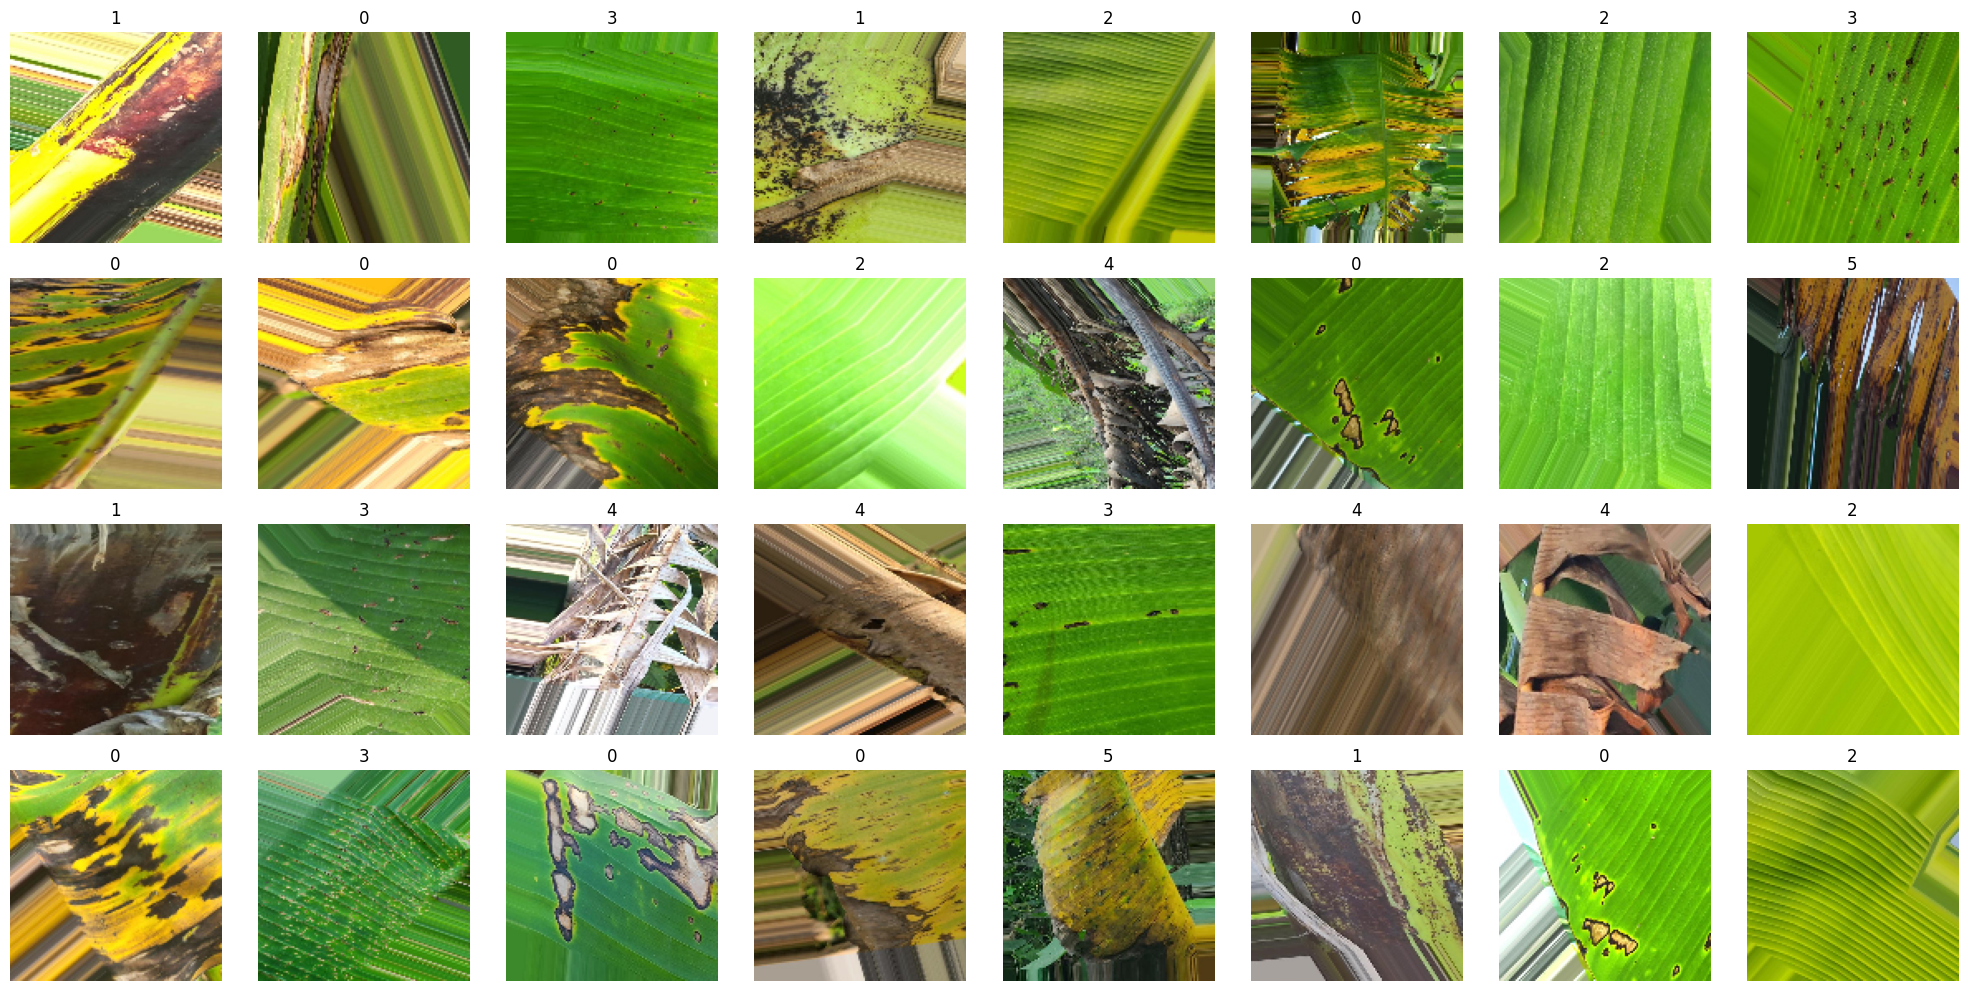

In [ ]:
images, labels = next(train_generator)

def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_images(images, labels)

In [ ]:
def apply_sobel(images_arr):
    sobel_images = []
    for img in images_arr:
        gray_img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
        sobel_x = sobel(gray_img, axis=0, mode='constant')
        sobel_y = sobel(gray_img, axis=1, mode='constant')
        sobel_img = np.hypot(sobel_x, sobel_y)
        sobel_images.append(sobel_img)
    return np.array(sobel_images)

sobel_images = apply_sobel(images)

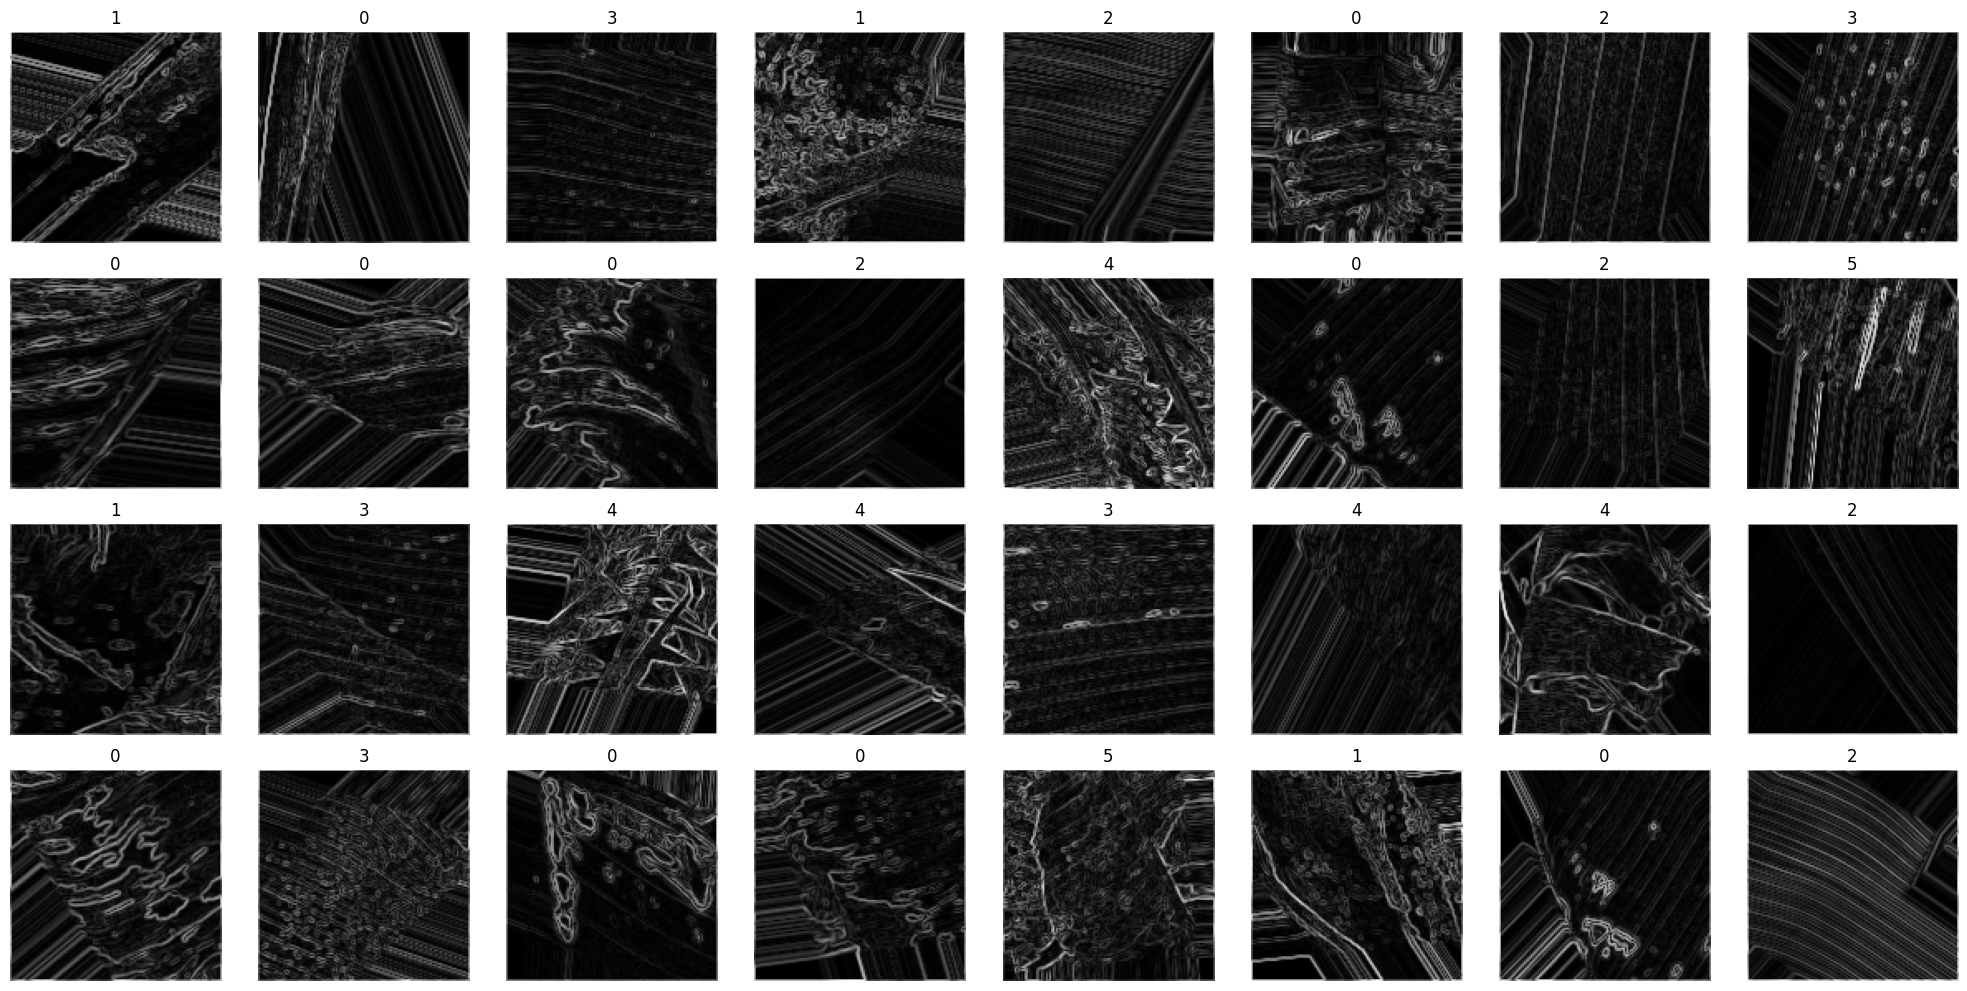

In [ ]:
def plot_sobel_images(original_images, sobel_images, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for orig_img, sob_img, lbl, ax in zip(original_images, sobel_images, labels_arr, axes):
        ax.imshow(sob_img, cmap='gray')
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_sobel_images(images, sobel_images, labels)

In [ ]:
model_lenet = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(7, activation='softmax')
])

In [ ]:
model_lenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_lenet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 58, 58, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 27, 27, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 27, 27, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │              

 Total params: 1,275,303 (4.86 MB)

 Trainable params: 1,273,575 (4.86 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [ ]:
history_lenet = model_lenet.fit(train_generator, epochs=50, validation_data=val_generator, class_weight=class_weights)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.2522 - loss: 2.6506 - precision: 0.2969 - recall: 0.1699 - val_accuracy: 0.2109 - val_loss: 4.6861 - val_precision: 0.2109 - val_recall: 0.2109
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.4010 - loss: 1.6651 - precision: 0.4364 - recall: 0.2915 - val_accuracy: 0.0562 - val_loss: 2.5324 - val_precision: 0.0737 - val_recall: 0.0562
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.4691 - loss: 1.4592 - precision: 0.5332 - recall: 0.3723 - val_accuracy: 0.2320 - val_loss: 2.7863 - val_precision: 0.3075 - val_recall: 0.2091
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.5115 - loss: 1.3121 - precision: 0.5742 - recall: 0.4075 - val_accuracy: 0.2548 - val_loss: 2.6034 - val_precision: 0.3048 - val_recall: 0.2320
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.5701 - loss: 1.1440 - precision: 0.6495 - recall: 0.4805 - val_accuracy: 0.2109 - val_loss: 3.8202 - 

## ResNet50 Model

In [ ]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model_resnet = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(7, activation='softmax')
])

In [ ]:
base_model_resnet.trainable = False
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
history_resnet = model_resnet.fit(train_generator, epochs=50, validation_data=val_generator, class_weight=class_weights)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 68s 807ms/step - accuracy: 0.2606 - loss: 1.8711 - precision_1: 0.3998 - recall_1: 0.0549 - val_accuracy: 0.0562 - val_loss: 2.3448 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 59s 806ms/step - accuracy: 0.4246 - loss: 1.5049 - precision_1: 0.5660 - recall_1: 0.1262 - val_accuracy: 0.0615 - val_loss: 2.3327 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 59s 811ms/step - accuracy: 0.4702 - loss: 1.3846 - precision_1: 0.6498 - recall_1: 0.1856 - val_accuracy: 0.1090 - val_loss: 2.4655 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 59s 807ms/step - accuracy: 0.5119 - loss: 1.2868 - precision_1: 0.6703 - recall_1: 0.2079 - val_accuracy: 0.1213 - val_loss: 2.1566 - val_precision_1: 1.0000 - val_recall_1: 0.0018
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 801ms/step - accuracy: 0.5343 - loss: 1.2874 - precision_1

In [ ]:
def plot_performance(history, title):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

In [ ]:
def evaluate_model(model, generator):
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)
    cr = classification_report(y_true, y_pred_classes, target_names=generator.class_indices.keys())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=generator.class_indices.keys(), yticklabels=generator.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print('Classification Report:')
    print(cr)

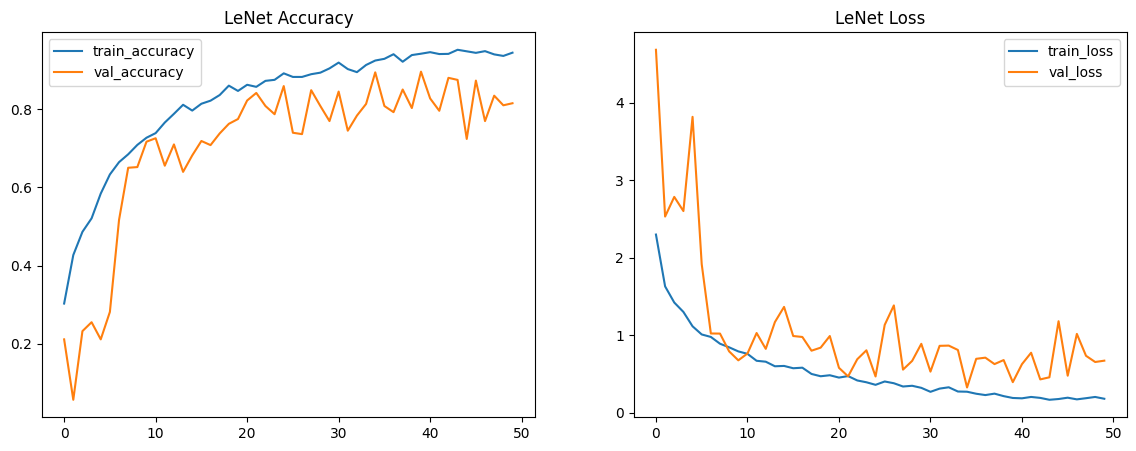

In [ ]:
plot_performance(history_lenet, 'LeNet')

18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 357ms/step


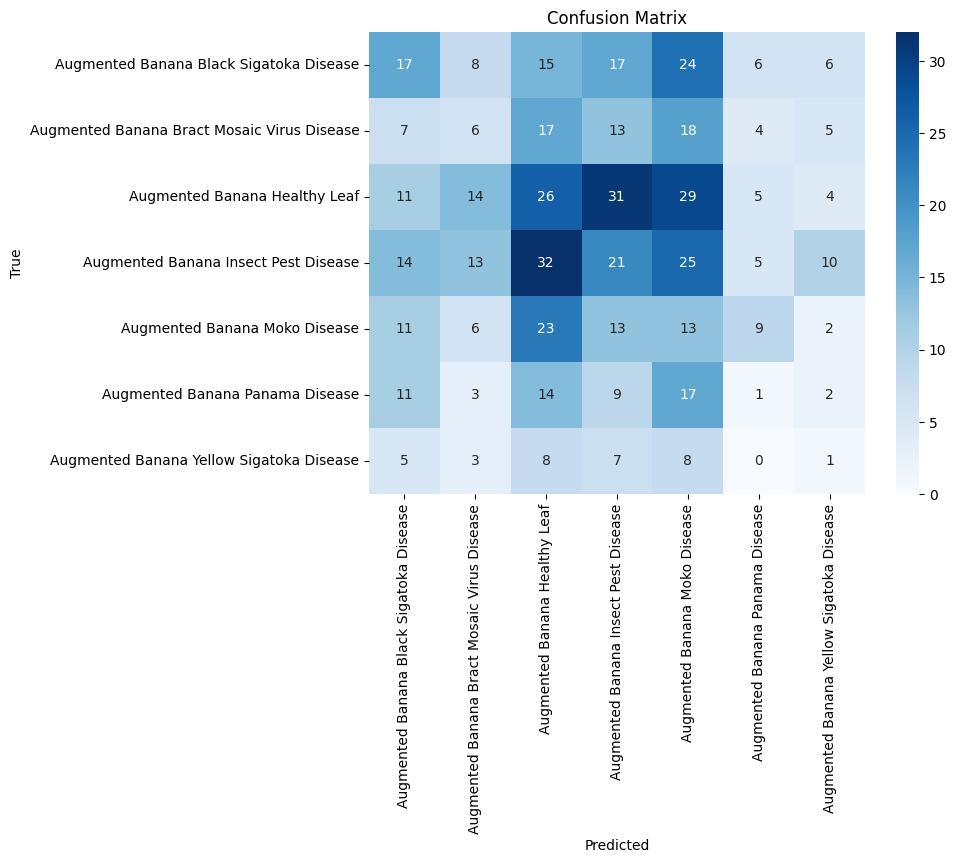

Classification Report:
                                             precision    recall  f1-score   support

    Augmented Banana Black Sigatoka Disease       0.22      0.18      0.20        93
Augmented Banana Bract Mosaic Virus Disease       0.11      0.09      0.10        70
              Augmented Banana Healthy Leaf       0.19      0.22      0.20       120
       Augmented Banana Insect Pest Disease       0.19      0.17      0.18       120
              Augmented Banana Moko Disease       0.10      0.17      0.12        77
            Augmented Banana Panama Disease       0.03      0.02      0.02        57
   Augmented Banana Yellow Sigatoka Disease       0.03      0.03      0.03        32

                                   accuracy                           0.15       569
                                  macro avg       0.13      0.13      0.12       569
                               weighted avg       0.15      0.15      0.15       569



In [ ]:
evaluate_model(model_lenet, val_generator)

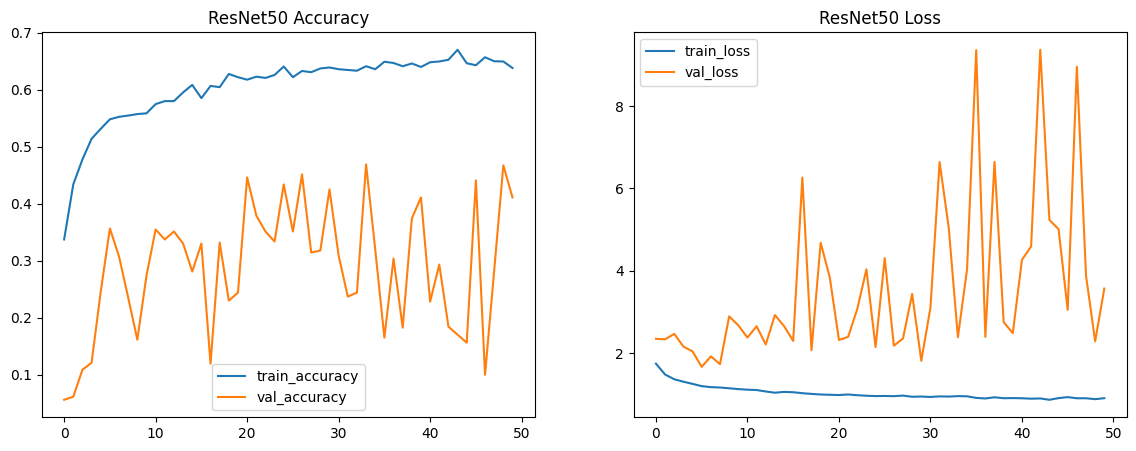

In [ ]:
plot_performance(history_resnet, 'ResNet50')

18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step 


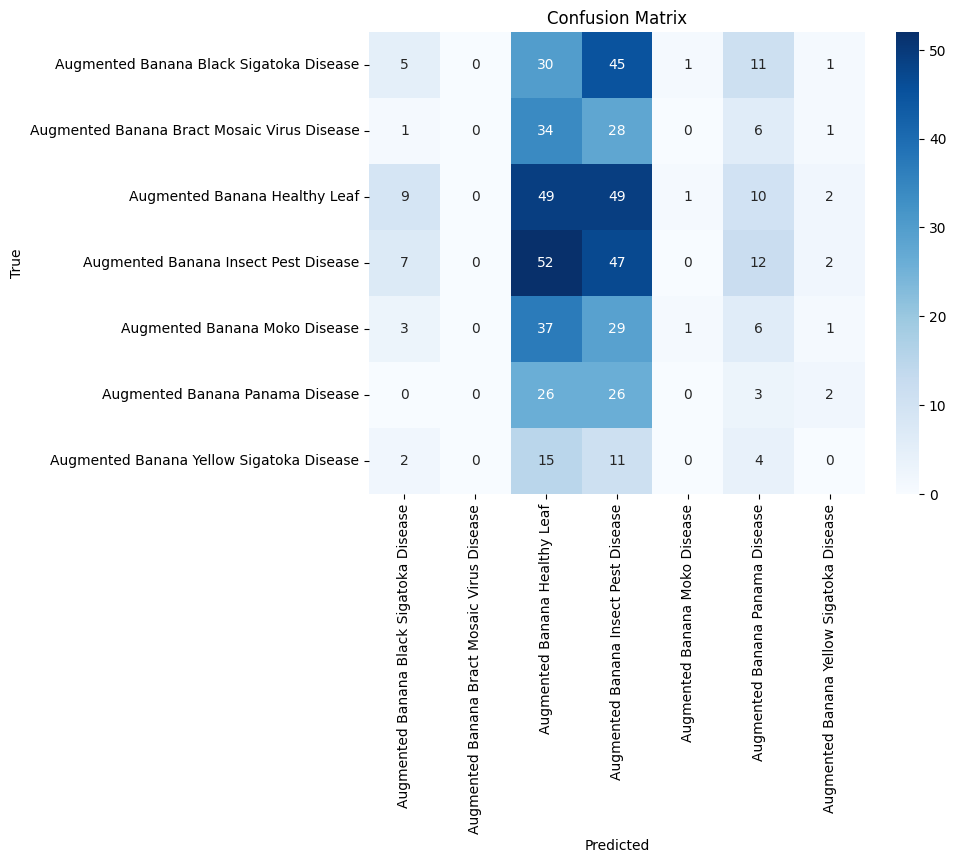

Classification Report:
                                             precision    recall  f1-score   support

    Augmented Banana Black Sigatoka Disease       0.19      0.05      0.08        93
Augmented Banana Bract Mosaic Virus Disease       0.00      0.00      0.00        70
              Augmented Banana Healthy Leaf       0.20      0.41      0.27       120
       Augmented Banana Insect Pest Disease       0.20      0.39      0.26       120
              Augmented Banana Moko Disease       0.33      0.01      0.03        77
            Augmented Banana Panama Disease       0.06      0.05      0.06        57
   Augmented Banana Yellow Sigatoka Disease       0.00      0.00      0.00        32

                                   accuracy                           0.18       569
                                  macro avg       0.14      0.13      0.10       569
                               weighted avg       0.17      0.18      0.14       569



In [ ]:
evaluate_model(model_resnet, val_generator)

In [ ]:
model_lenet.save('model_lenet.keras')

In [ ]:
model_resnet.save('model_resnet.keras')

In [ ]:
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

class_mapping = {
    0: "Banana Black Sigatoka Disease",
    1: "Banana Bract Mosaic Virus Disease",
    2: "Banana Healthy Leaf",
    3: "Banana Insect Pest Disease",
    4: "Banana Moko Disease",
    5: "Banana Panama Disease",
    6: "Banana Yellow Sigatoka Disease"
}

# Function to predict using each model and aggregate predictions
def predict_with_voting(image_path):
    input_size = (128, 128)

    img_lenet = preprocess_image(image_path, input_size)
    img_resnet = preprocess_image(image_path, input_size)

    # Step 1: Make predictions using each model
    pred_lenet = model_lenet.predict(img_lenet)
    pred_resnet = model_resnet.predict(img_resnet)

    # Step 2: Aggregate predicted probabilities (soft voting)
    # Soft voting: Average the predicted probabilities
    final_pred_prob = (pred_lenet + pred_resnet) / 2

    # Step 3: Predict class based on the aggregated probabilities
    final_pred_class = np.argmax(final_pred_prob, axis=1)

    # Map predicted class indices to disease names
    final_pred_disease = [class_mapping[class_index] for class_index in final_pred_class]

    return final_pred_disease

image_path = 'main_dataset/Dataset - II/Augmented images/Augmented images/Augmented Banana Healthy Leaf/Augmented Banana Healthy Leaf (102).jpg'
predicted_class = predict_with_voting(image_path)
print("Predicted Class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: ['Banana Healthy Leaf']


In [ ]:
image_path = 'main_dataset/Dataset - II/Augmented images/Augmented images/Augmented Banana Panama Disease/Augmented Banana Panama Disease (10).jpg'
predicted_class = predict_with_voting(image_path)
print("Predicted Class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Class: ['Banana Panama Disease']
